Sources used:

* https://docs.pinecone.io/docs/overview
* https://docs.pinecone.io/docs/ecommerce-search
* https://docs.pinecone.io/docs/hybrid-search
* https://www.pinecone.io/learn/clip-image-search/
* https://github.com/pinecone-io/pinecone-text
* https://pypi.org/project/pinecone-text/0.3.4/

# Install packages and load the dataset

In [ ]:
!pip install -qU transformers sentence-transformers pinecone-client[grpc] pinecone-text

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import time
import pinecone
from pinecone_text.sparse import BM25Encoder
from transformers import CLIPModel, CLIPTokenizer, CLIPProcessor
from tqdm.auto import tqdm
from PIL import Image
from itertools import chain



In [ ]:
!unzip fashion.zip

In [5]:
filename = "./myntradataset/styles.csv"
df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas

available_ids = os.listdir("./myntradataset/images")
available_ids = [int(x.replace(".jpg","")) for x in available_ids]
df = df[df.id.isin(available_ids)] #some images are not actually available
df = df.dropna(subset='productDisplayName')

df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [6]:
def display_images_and_titles(filepaths, titles):
    # Create a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()

    display_images_and_titles(filepaths, titles)




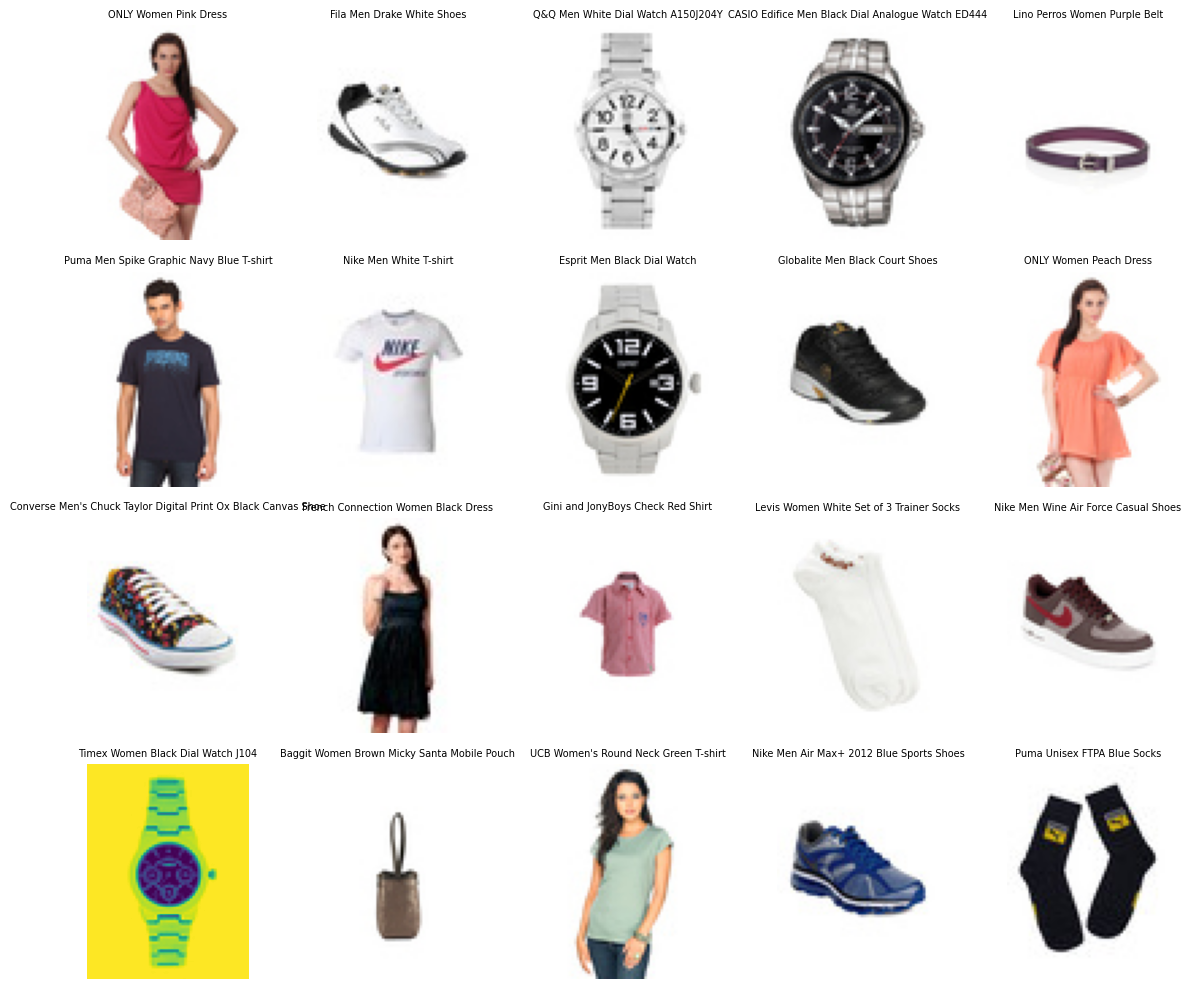

In [7]:
# Display 20 random images
directory = "./myntradataset/images/"
random_subset = df.iloc[np.random.randint(0,df.shape[0], size = 20)]
filenames = random_subset.id.astype(str).tolist()
filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
titles = random_subset.productDisplayName.tolist()

display_images_and_titles(filepaths, titles)

# Start working with Pinecone

In [8]:
# PINECONE_API_KEY = 'your_key_goes_here (with quotation marks)'
PINECONE_API_KEY = '...'

In [9]:
# You need to get your Pinecone API key at app.pinecone.io (it takes a minute)
api_key = PINECONE_API_KEY

# You also need to find out the name of your environment (you will see it on the same page where you get your API key)
environment = "..."

In [10]:
# Initiallize connection to pinecone
pinecone.init(api_key=api_key, environment=environment)

In [11]:
# Get the list of current pinecone indices (should be empty at first)
pinecone.list_indexes()

['multimodal-search-from-image-tensor']

To use the `sparse-dense` index in Pinecone we must set `metric="dotproduct"` and use either `s1` or `p1` pods. We also align the `dimension` value to that of our retrieval model, which outputs `512`-dimensional vectors.

In [ ]:
# Choose index name
index_name = "multimodal-search-from-image-tensor"

# Create the index
if index_name not in pinecone.list_indexes():
      pinecone.create_index(
      index_name,
      dimension=512,
      metric="dotproduct",
      pod_type="s1"
    )

In [12]:
# Check if the index has been created
pinecone.list_indexes()

['multimodal-search-from-image-tensor']

In [13]:
index_name = pinecone.list_indexes()[0]

In [14]:
# Connect to the index
index = pinecone.GRPCIndex(index_name)

# Sparse vectors via BM25

In [15]:
# Create a BM25Encoder object (we imported BM25Encoder from pinecone_text.sparse at the very beginning)
bm25 = BM25Encoder()

In [16]:
# Fit the BM25Encoder object to the product titles:
metadata = df
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44412 [00:00<?, ?it/s]

In [17]:
# An example of a sparse vector:
bm25.encode_documents(metadata['productDisplayName'][55])
# Indices indicate the positions that have nonzero values.
# The values at all other positions are zero.

{'indices': [587940662,
  632192512,
  691409538,
  4052836434,
  2436024751,
  3489280082,
  64068809],
 'values': [0.4158730674720621,
  0.4158730674720621,
  0.4158730674720621,
  0.4158730674720621,
  0.4158730674720621,
  0.4158730674720621,
  0.4158730674720621]}

# Dense vectors via CLIP image embeddings

In [ ]:
# You don't need to run this cell if you have no trouble creating a CLIP model
# If you have errors, try running this cell (you might need to modify the path)
# Also see https://stackoverflow.com/questions/71759248/importerror-cannot-import-name-builder-from-google-protobuf-internal

!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
!mv builder.py /usr/local/lib/python3.10/dist-packages/google/protobuf/internal/builder.py


In [19]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [20]:
# Set the device

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

In [24]:
def get_single_text_embedding(text):
  """
  Function to get the embedding of a single text using a given tokenizer and model.

  Args:
  - text: The input text to be embedded.

  Returns:
  - The embedding of the input text as a NumPy array.
  """

  # Tokenize the input text using the provided tokenizer and move the inputs to the desired device (CPU or GPU).
  inputs = tokenizer(text, return_tensors="pt").to(device)

  # Get the text embeddings from the model using the tokenized inputs.
  text_embeddings = model.get_text_features(**inputs)

  # Convert the text embeddings to a NumPy array for easier handling.
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  # Return the resulting text embedding as a NumPy array.
  return embedding_as_np


In [22]:
def get_single_image_embedding(my_image):
  """
  Function to get the embedding of a single image using a given image processor and model.

  Args:
  - my_image: The input image to be embedded.

  Returns:
  - The embedding of the input image as a NumPy array.
  """

  # Process the input image using the provided image processor and move the resulting tensor to the desired device (CPU or GPU).
  image = processor(
      text=None,
      images=my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  # Get the image embeddings from the model using the processed image tensor.
  embedding = model.get_image_features(image)

  # Convert the image embeddings to a NumPy array for easier handling.
  embedding_as_np = embedding.cpu().detach().numpy()

  # Return the resulting image embedding as a NumPy array.
  return embedding_as_np


In [25]:
# An example of a dense vector from text:
get_single_text_embedding(metadata['productDisplayName'][55])

array([[ 1.30549997e-01, -1.91652104e-02, -2.88573295e-01,
         2.53239751e-01, -1.41785443e-01,  1.07903466e-01,
        -2.44477481e-01,  2.50299662e-01,  2.81276554e-01,
         1.89239204e-01, -1.17372848e-01,  3.56025174e-02,
        -1.79754198e-03, -1.21484175e-01, -3.91267627e-01,
         4.53873158e-01,  4.28417623e-01,  3.68044674e-01,
        -1.73113197e-01,  6.19374573e-01,  2.65591711e-01,
         5.56425750e-02,  1.66429549e-01, -7.55925924e-02,
         3.27735871e-01,  1.78973883e-01,  2.69945860e-02,
         1.67426914e-02,  1.62928075e-01, -3.85607690e-01,
         6.96456134e-02,  1.96737617e-01,  6.99147224e-01,
         2.52431989e-01, -2.88414240e-01, -2.79870749e-01,
         6.15249127e-02, -1.21088237e-01, -3.16672027e-01,
        -1.35168694e-02, -1.49107844e-01, -3.38705540e-01,
         1.76147610e-01, -1.18536726e-02, -1.38848096e-01,
         2.63890296e-01,  3.43036234e-01, -7.42040798e-02,
         2.97619373e-01, -6.39997005e-01, -2.35233307e-0

# Upserting


In [26]:
metadata = df

directory = "./myntradataset/images/"
batch_size = 200

# Clean metadata values
metadata_cleaned = metadata.fillna("").astype(str)

# Load the preprocessed image tensor
image_tensor = torch.load('image_tensor.pt')


In [ ]:
# Upserting process

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i + batch_size, len(df))
    # extract metadata batch
    meta_batch = metadata_cleaned.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatenate all metadata fields except for id and year to form a single string
    meta_batch = [" ".join(str(x) for x in row) for row in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch IDs
    img_ids = df['id'].iloc[i:i_end].tolist()
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents(meta_batch)

    # create dense vectors
    dense_embeds = image_tensor[i:i_end]

    # get the corresponding IDs from the dataframe
    ids = df['id'].iloc[i:i_end].astype(str).tolist()

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        # Convert the dense embeddings to a list of floats
        dense_list = dense.reshape(-1).tolist()
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense_list,
            'metadata': meta
        })

    # upload the documents to the new hybrid index
    index.upsert(upserts)


  0%|          | 0/223 [00:00<?, ?it/s]

# Querying

Let's start with a simple text search.

In [27]:
directory = "./myntradataset/images/"

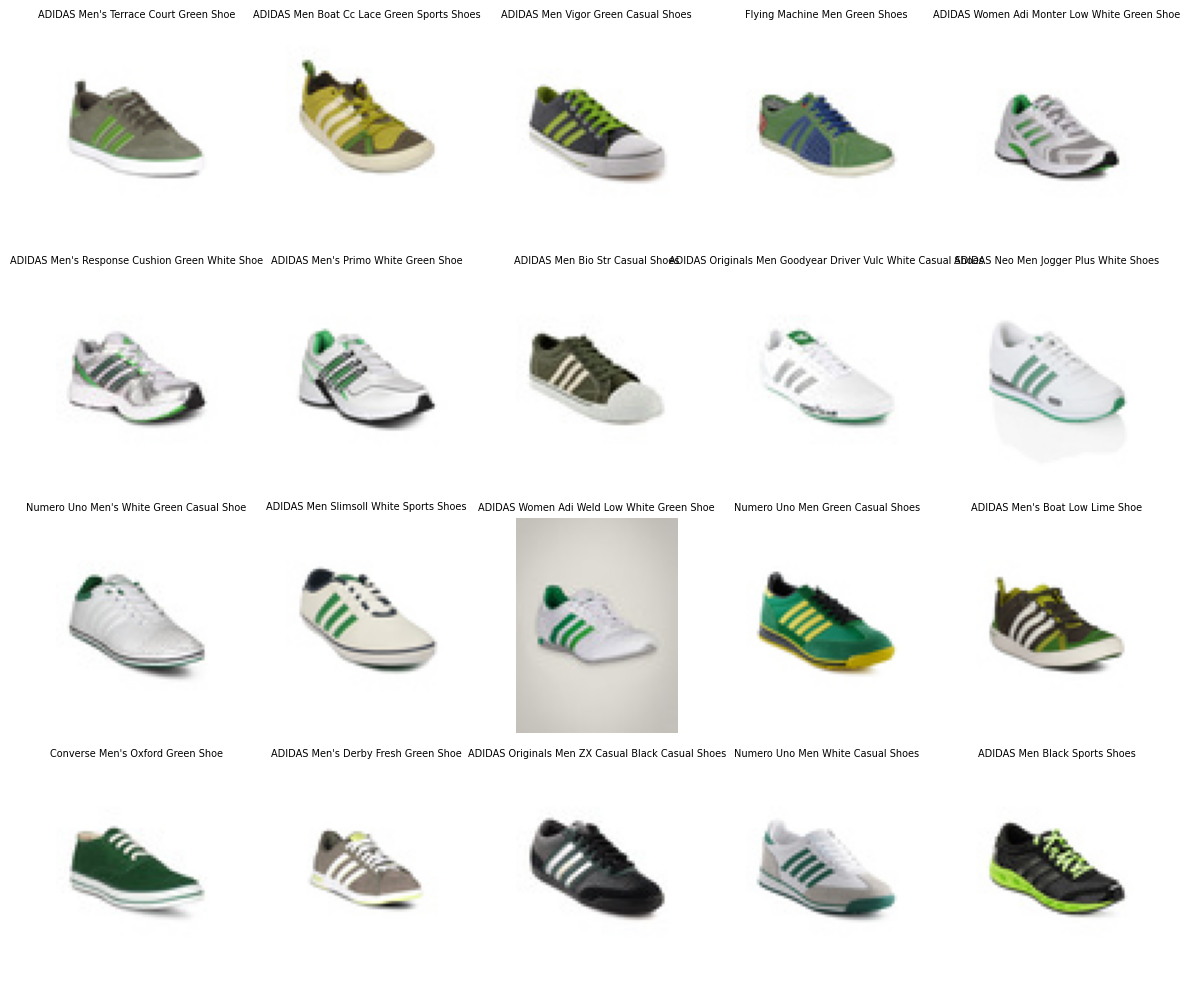

In [47]:
query = "adidas green shoes for men"

# Create sparse and dense vectors
sparse = bm25.encode_queries([query])[0]

# Get the dense vector for the text query using the custom function
dense = get_single_text_embedding(query)

# Convert the dense vector to a list of floats
dense_list = dense.reshape(-1).tolist()

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=dense_list,
    sparse_vector=sparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)

We can now refine the search by putting weights on the dense and sparse vectors.


In [31]:
# Define a function that allows for weights of dense-sparse vectors

def hybrid_scale(dense, sparse, alpha: float):
    """Scales a dense vector and a sparse vector using a convex combination.

    Args:
        dense: Nested list of floats representing the dense vector.
        sparse: A dictionary with 'indices' and 'values' representing the sparse vector.
        alpha: Float between 0 and 1 where 0 represents the sparse vector only and 1 represents the dense vector only.

    Returns:
        Tuple of the scaled dense vector and the scaled sparse vector.
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")

    # Scale the sparse vector
    hsparse = {
        'indices': sparse['indices'],
        'values': [v * (1 - alpha) for v in sparse['values']]
    }

    # Scale the dense vector
    hdense = [[v * alpha for v in sublist] for sublist in dense]

    return hdense, hsparse


Example using weights:

* Setting `alpha=1` performs a search based on the dense vector, resulting in a purely semantic search in the titles. It considers the similarity of the text embeddings rather than finding an exact match in the titles.
* Setting `alpha=0` performs a search based on the sparse vector, finding an exact text match in the titles using BM25.

You can choose any value between 0 and 1 to control the balance between semantic search and exact text match.

Let's first try `alpha=1`. The output consists entirely of shoes, with a mix of men's and women's shoes. Additionally, the results include both Adidas and non-Adidas shoes.





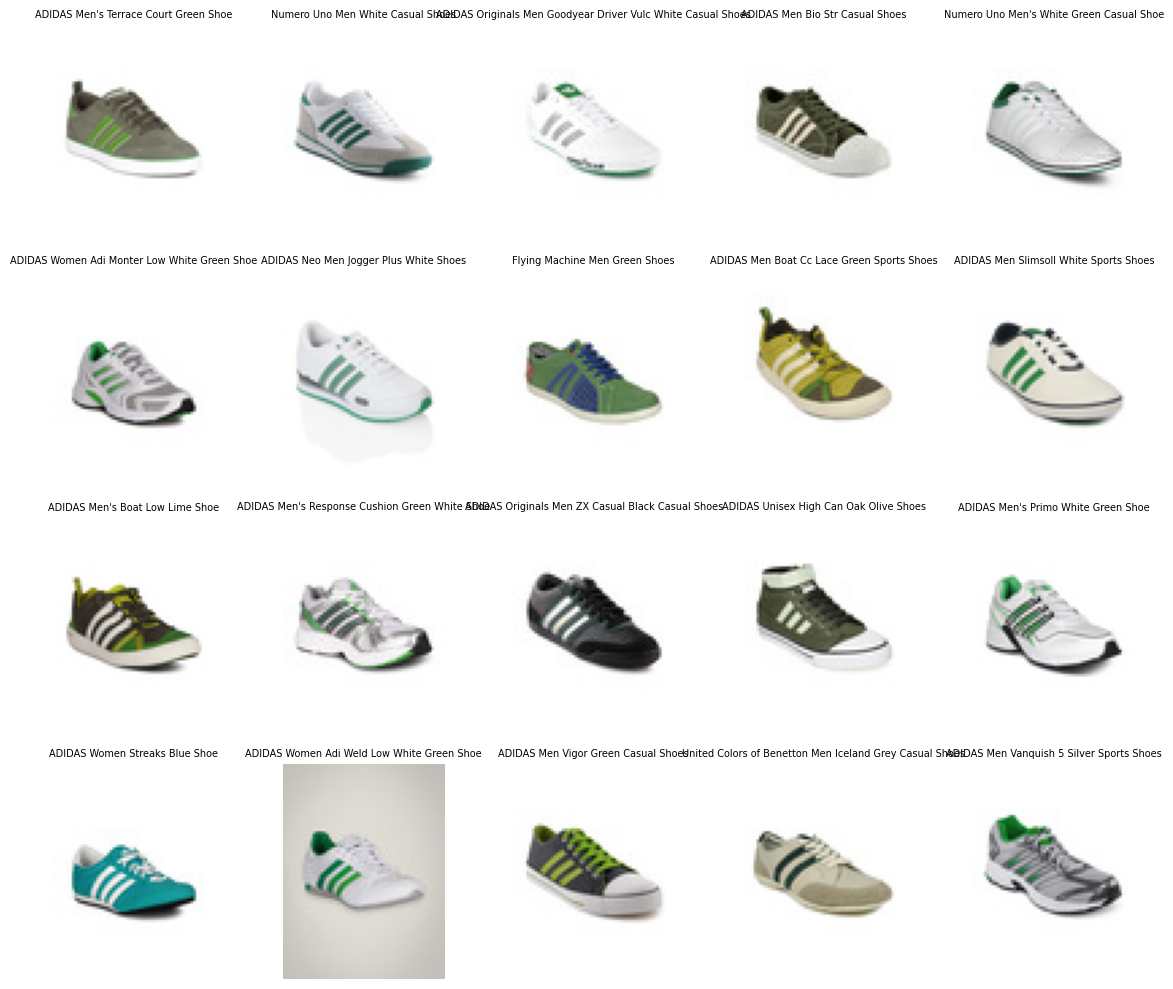

In [48]:
query = "adidas green shoes for men"

# Create sparse and dense vectors
sparse = bm25.encode_queries([query])[0]
dense = get_single_text_embedding(query).tolist()

# Set the alpha value for hybrid scaling (e.g., alpha=1 for dense vector only)
alpha = 1

# Perform the hybrid scaling
hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)

# Flatten the hdense list
hdense_flat = list(chain.from_iterable(hdense))

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense_flat,
    sparse_vector=hsparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)


Now let's try the other extreme: `alpha=0`, i.e., BM25 search. We get some irrelevant results at the end.

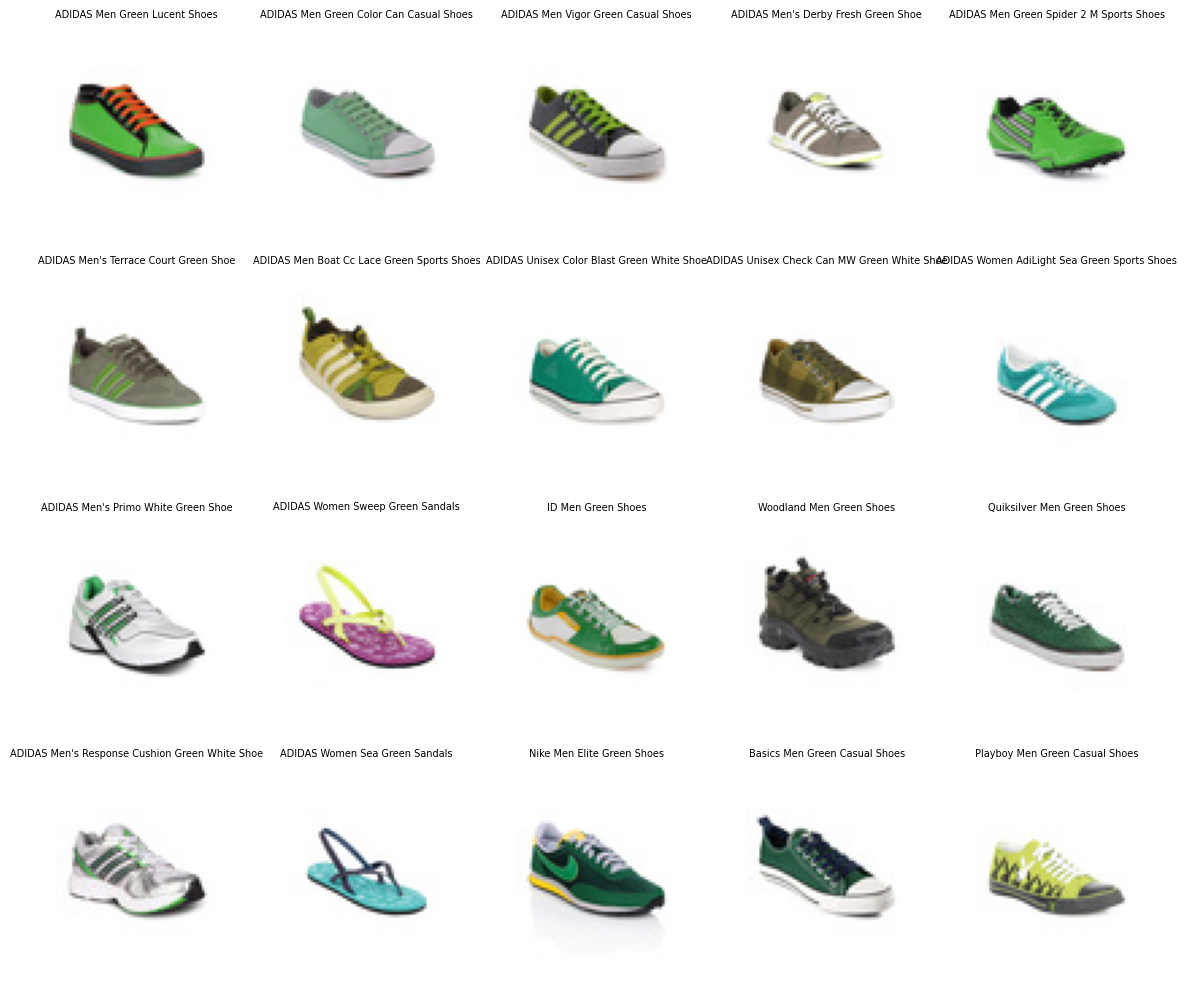

In [45]:
query = "adidas green shoes for men"

# Create sparse and dense vectors
sparse = bm25.encode_queries([query])[0]
dense = get_single_text_embedding(query).tolist()

# Set the alpha value for hybrid scaling (e.g., alpha01 for sparse vector only)
alpha = 0

# Perform the hybrid scaling
hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)

# Flatten the hdense list
hdense_flat = list(chain.from_iterable(hdense))

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense_flat,
    sparse_vector=hsparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)


If we slightly increase `alpha`, from `0` to `0.2`, then the irrelevant results disappear:

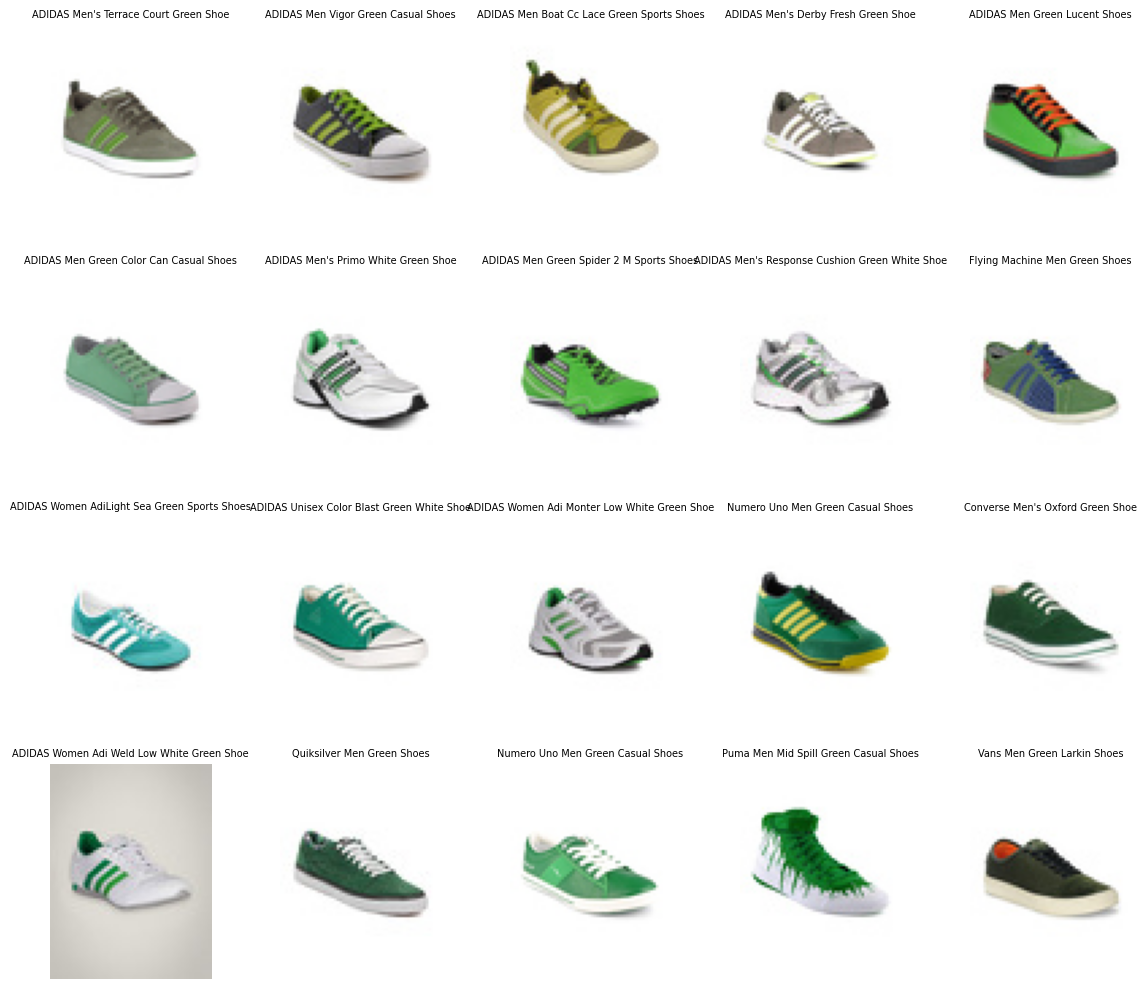

In [50]:
query = "adidas green shoes for men"

# Create sparse and dense vectors
sparse = bm25.encode_queries([query])[0]
dense = get_single_text_embedding(query).tolist()

alpha = 0.2

# Perform the hybrid scaling
hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)

# Flatten the hdense list
hdense_flat = list(chain.from_iterable(hdense))

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense_flat,
    sparse_vector=hsparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)


We can also add metadata filtering:

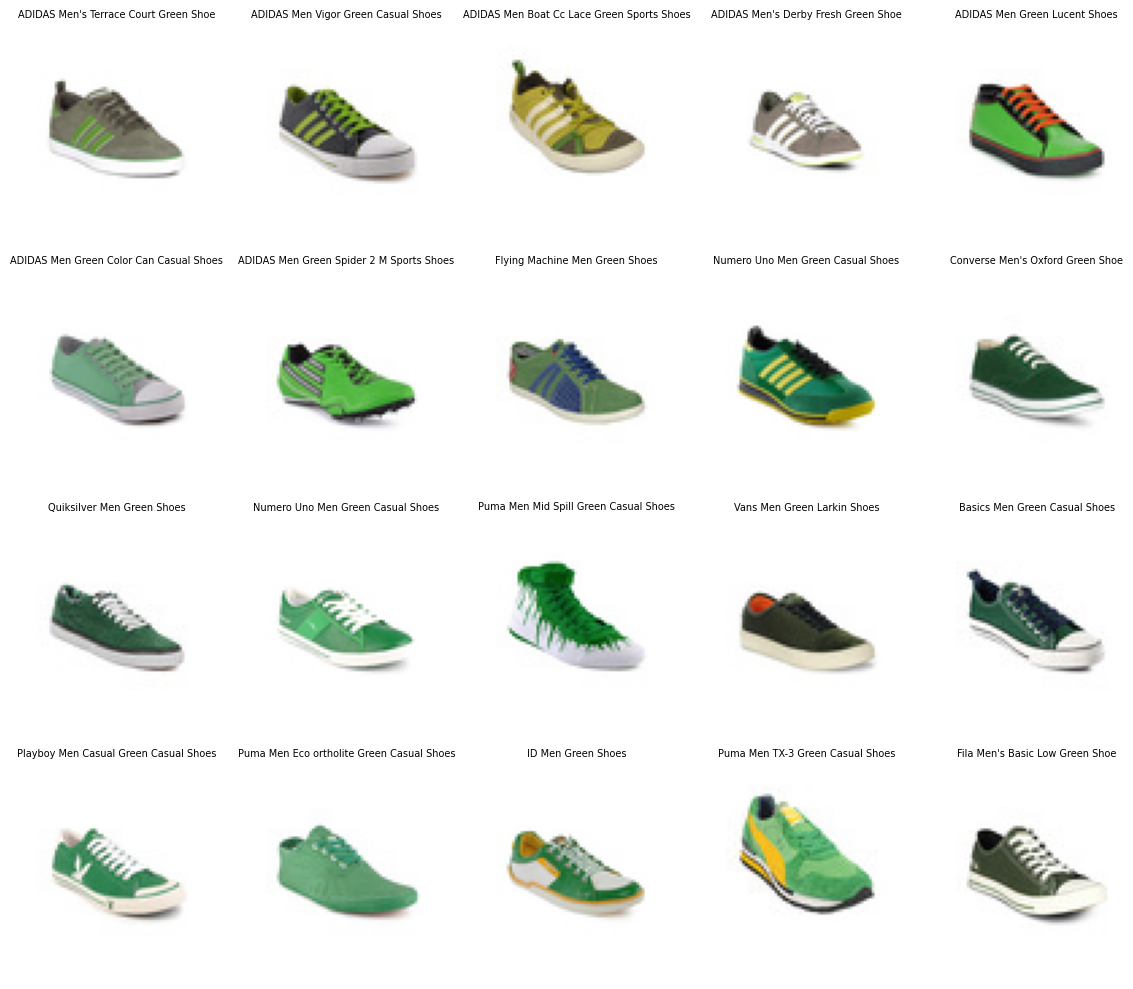

In [55]:
query = "adidas green shoes for men"

# Create sparse and dense vectors
sparse = bm25.encode_queries([query])[0]
dense = get_single_text_embedding(query).tolist()

alpha = 0.2

# Perform the hybrid scaling
hdense, hsparse = hybrid_scale(dense, sparse, alpha=alpha)

# Flatten the hdense list
hdense_flat = list(chain.from_iterable(hdense))

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense_flat,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green", "gender" : "Men"}  # add metadata filter
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)


Now let's use image (and text) search. First, upload a picture.

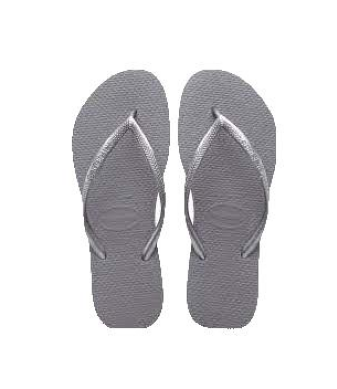

In [56]:
image_path = "./flipflops.jpeg"
im = Image.open(image_path)

plt.imshow(im)
plt.axis('off')
plt.show()

Let's search for similar pictures this without any weights. We commented out the sparse part of the search because we don't have a text query (yet).

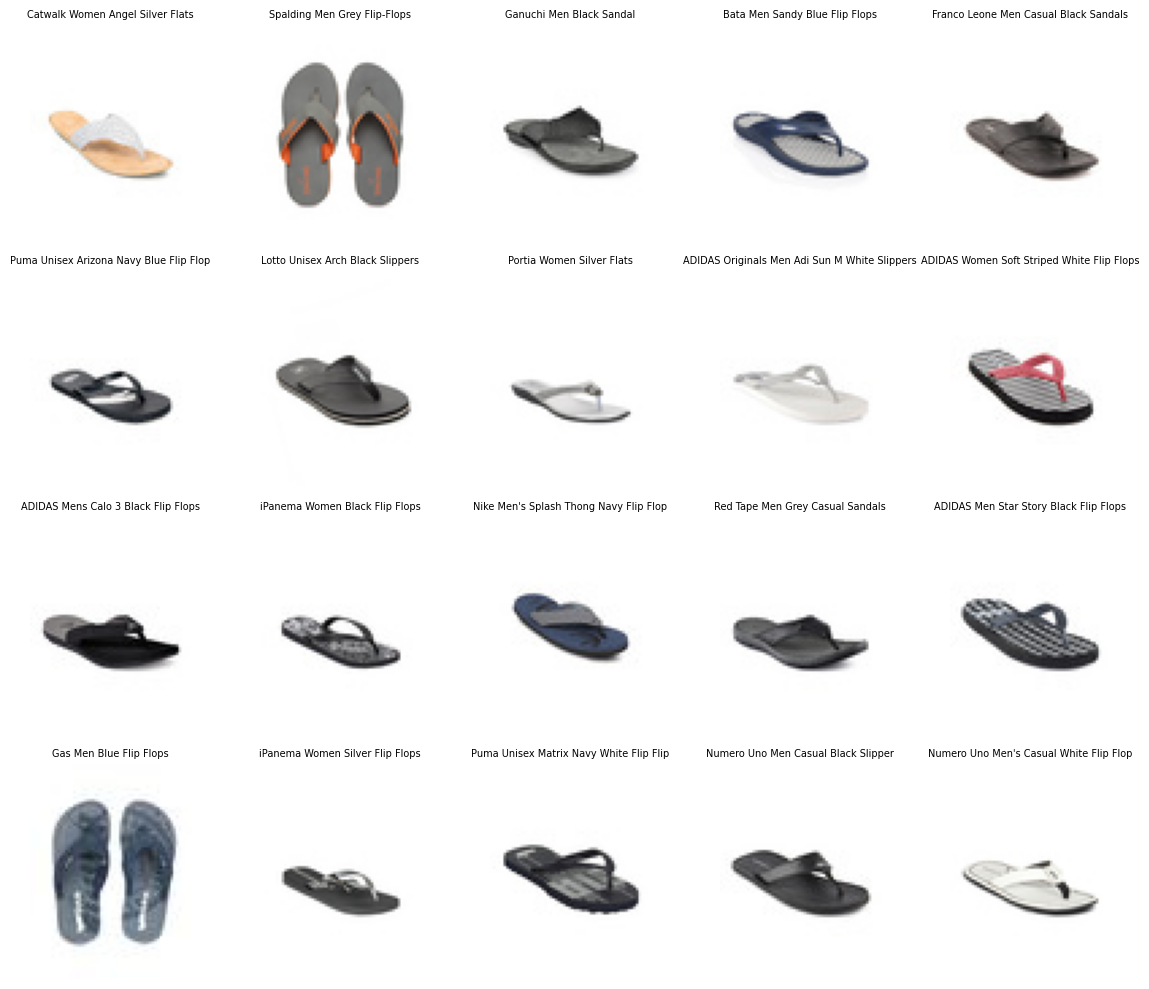

In [58]:
query = ""

# Create sparse vector using BM25
sparse = bm25.encode_queries([query])[0]

# Get single image embedding using the custom function
dense = get_single_image_embedding(im).tolist()
# Flatten the nested list to create a flat list of numerical values
dense = np.ravel(dense).tolist()

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=dense,
   # sparse_vector=sparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)

If we add text query `green`, and set `alpha=0.001`, we will get all kinds of results but all of them will contain `green` in the title. This is almost purely BM25 search.

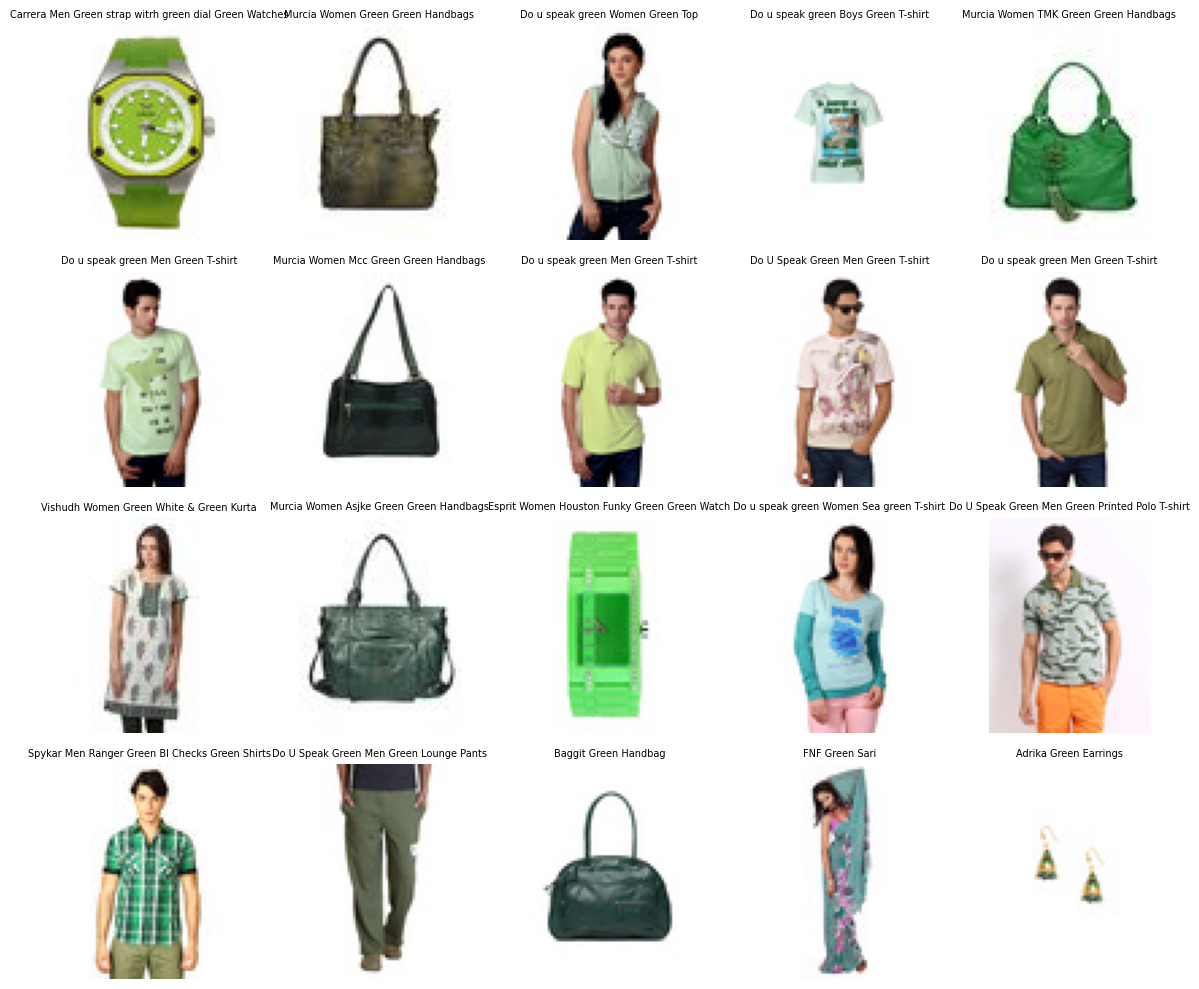

In [59]:
query = 'green'

# Create the sparse vector
sparse = bm25.encode_queries([query])[0]

# Get single image embedding using the custom function
dense = get_single_image_embedding(im)
# Convert the dense vector to a list of Python floats
dense = dense.flatten().tolist()

# Scale sparse and dense vectors using hybrid_scale function
hdense, hsparse = hybrid_scale([dense], sparse, alpha=0.001)

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense[0],  # Extract the first element since hdense is a nested list with one element
    sparse_vector=hsparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)


Here are more reasonable results with `alpha=0.2`.

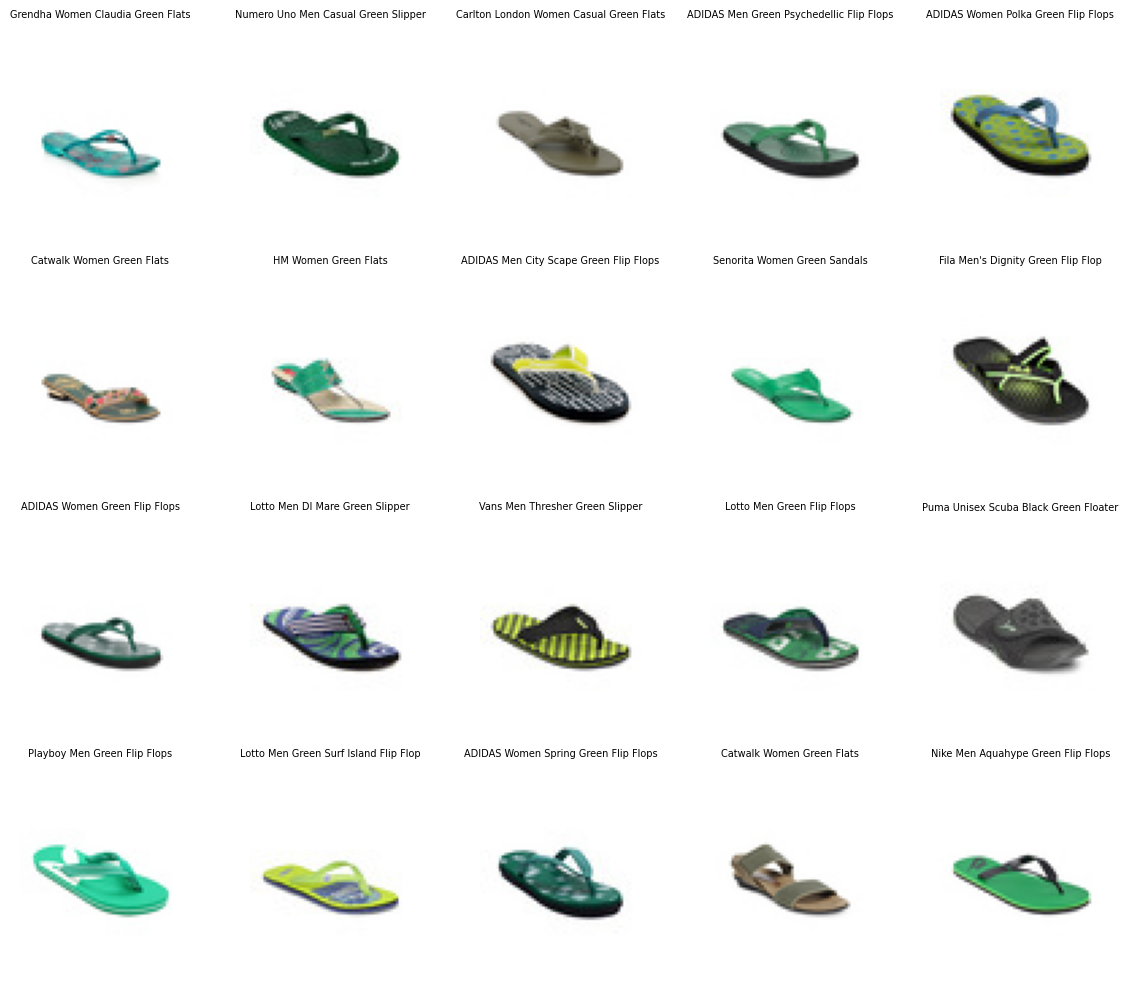

In [61]:
query = 'green'

# Create the sparse vector
sparse = bm25.encode_queries([query])[0]

# Get single image embedding using the custom function
dense = get_single_image_embedding(im)
# Convert the dense vector to a list of Python floats
dense = dense.flatten().tolist()

# Scale sparse and dense vectors using hybrid_scale function
hdense, hsparse = hybrid_scale([dense], sparse, alpha=0.2)

# Perform the search and include metadata
result = index.query(
    top_k=20,
    vector=hdense[0],  # Extract the first element since hdense is a nested list with one element
    sparse_vector=hsparse,
    include_metadata=True
)

# Extract the product IDs from the search result
product_ids = [r["id"] for r in result["matches"]]

# Display images and titles for the products
display_images_titles_from_ids(product_ids, directory)
